In [29]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random

In [77]:
resolution = 592.747
round_resolution = round(resolution)
image_path = 'dataset/images/'
label_path = image_path.replace('images', 'labels')
image_names = os.listdir(label_path)

28_-121_v
14_-98_h
8_-112_h


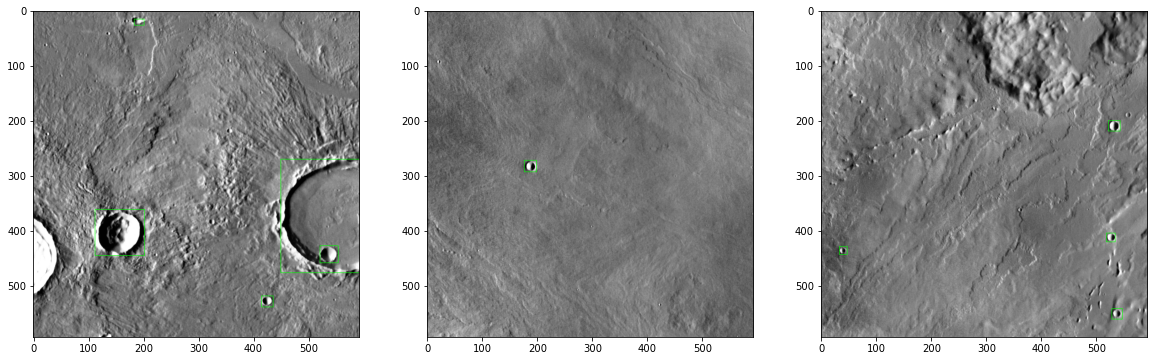

In [97]:
random.shuffle(image_names)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    image_name = image_names[i][:-4]
    im = cv2.imread(image_path + image_name + '.png')
    label_name = image_name + '.txt'
    print(image_name)
    f = open(label_path + label_name, 'r')
    for line in f.readlines():
        c, x, y, w, h, id = line.split(' ')
        x1 = int((float(x) - float(w) / 2) * 593)
        y1 = int((float(y) - float(h) / 2) * 593)
        x2 = int((float(x) + float(w) / 2) * 593)
        y2 = int((float(y) + float(h) / 2) * 593)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 1)
    f.close()
    ax[i].imshow(im)

In [20]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_list = os.listdir('dataset/images')

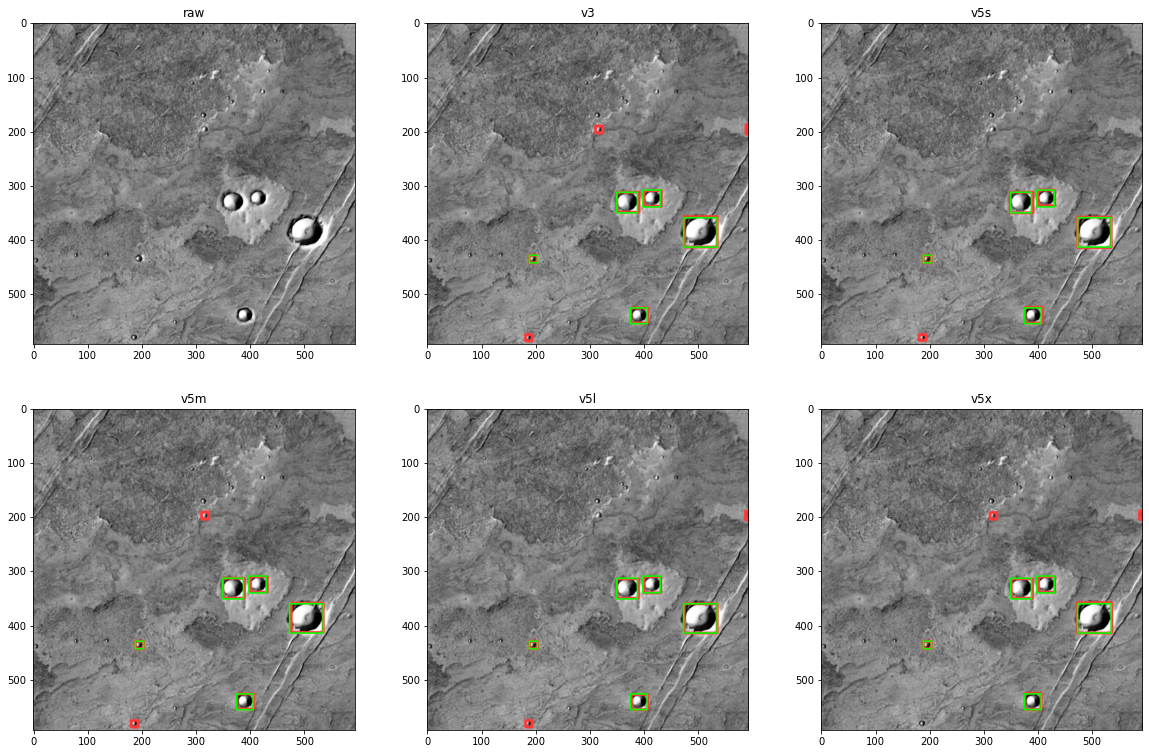

In [39]:
random.shuffle(image_list)
for image_name in image_list[:1]:
    plt.figure(figsize=(20, 13))

    # origin pic
    plt.subplot(2, 3, 1)
    raw_pic = mpimg.imread('dataset/images/' + image_name)
    plt.imshow(raw_pic, cmap='gray')
    plt.title('raw')

    # v3
    plt.subplot(2, 3, 2)
    pic = mpimg.imread('detect/v3/' + image_name)
    plt.imshow(pic)
    plt.title('v3')

    # v5s
    plt.subplot(2, 3, 3)
    pic = mpimg.imread('detect/v5s/' + image_name)
    plt.imshow(pic)
    plt.title('v5s')

    # v5m
    plt.subplot(2, 3, 4)
    pic = mpimg.imread('detect/v5m/' + image_name)
    plt.imshow(pic)
    plt.title('v5m')

    # v5l
    plt.subplot(2, 3, 5)
    pic = mpimg.imread('detect/v5l/' + image_name)
    plt.imshow(pic)
    plt.title('v5l')

    # v5x
    plt.subplot(2, 3, 6)
    pic = mpimg.imread('detect/v5x/' + image_name)
    plt.imshow(pic)
    plt.title('v5x')

# Select 2a2b dataset

In [42]:
f = open('combined/loss_rank.csv', 'r')
print(f.readline())
rank = [(line.split(',')[0], *[float(loss) for loss in line.split(',')[1:]]) for line in f.read().splitlines()]


img,box,obj,cls,loss



In [48]:
# 2a
# size = 1800
size = 2400

rank.sort(key=lambda loss: loss[1])
accurate = rank[:size]

rank.sort(key=lambda loss: loss[2])
clean = rank[:size]

# data_2a = set(['_'.join(loss[0].split('_')[:2]) + '.png\n' for loss in clean if loss in accurate])
data_2a = [loss[0] + '.png\n' for loss in clean if loss in accurate]
print(len(data_2a) / len(rank))

f = open('combined/data_2a.txt', 'w')
f.writelines(data_2a)
f.close()

0.2072228144989339


In [52]:
# 2b
# size = 4100
size = 4400

rank.sort(key=lambda loss: loss[1])
accurate = rank[:size]

rank.sort(key=lambda loss: -loss[2])
dirty = rank[:size]

# data_2b = set(['_'.join(loss[0].split('_')[:2]) + '.png\n' for loss in accurate if loss in dirty])
data_2b = [loss[0] + '.png\n' for loss in dirty if loss in accurate]
print(len(data_2b) / len(rank))

f = open('data_2b.txt', 'w')
f.writelines(data_2b)
f.close()

0.2084221748400853


# Count confidence

In [53]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def xywh2xyxy(x, y, w, h):
    x, y, w, h = float(x), float(y), float(w), float(h)
    return x - w / 2, y - h / 2, x + w / 2, y + h / 2

# calculate area of a box
def area(x1, y1, x2, y2):
    return (x2 - x1) * (y2 - y1)

# calculate iou of two boxes
def iou(box1, box2):
    '''
    box1 = [x1, y1, x2, y2]
    box2 = [x1, y1, x2, y2]
    '''
    # calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # no overlap
    if x1 > x2 or y1 > y2:
        return 0.
    
    intersection_area = area(x1, y1, x2, y2)
    union_area = area(*box1) + area(*box2) - intersection_area
    
    return intersection_area / union_area


true_list = []
false_list = []

f = open('combined/data_2b.txt')
image_name_list = f.read().splitlines()
f.close()

f = open('combined/data_2a.txt')
image_name_list += f.read().splitlines()
f.close()

# image_name_list = os.listdir('combined/yolo_labels')

for img_name in tqdm(image_name_list):
    gt_label_file = open('combined/labels/' + img_name[:-4] + '.txt', 'r')

    gt_labels = []
    # show gt labels
    for line in gt_label_file.read().splitlines():
        x1, y1, x2, y2 = xywh2xyxy(*line.split()[1: 5])
        gt_labels.append((x1, y1, x2, y2))
    
    gt_label_file.close()

    

    yolo_label_file = open('combined/yolo_labels/' + img_name[:-4] + '.txt', 'r')
    for line in yolo_label_file.read().splitlines():
        x1, y1, x2, y2 = xywh2xyxy(*line.split()[1: 5])
        conf = float(line.split()[5])
        if conf < 0.1:
            continue
        for gt_label in gt_labels:
            if iou(gt_label, (x1, y1, x2, y2)) >= 0.5:
                true_list.append(conf)
                conf = 100
                break
        if conf != 100:
            false_list.append(conf)

    yolo_label_file.close()

100%|██████████| 1938/1938 [00:00<00:00, 4045.19it/s]


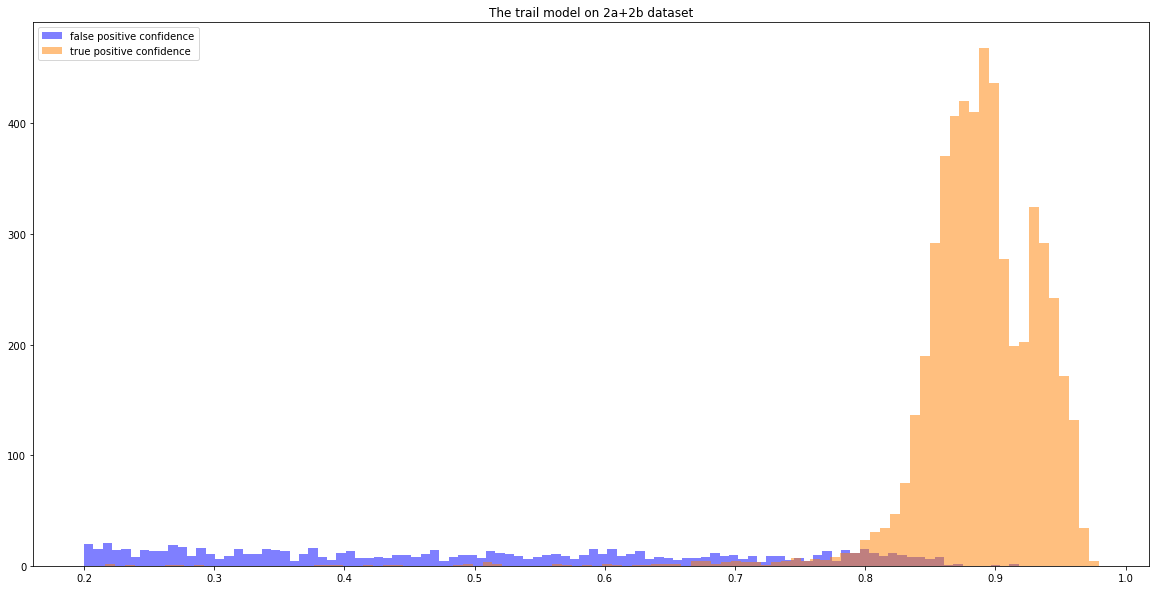

In [54]:
plt.figure(figsize=(20,10))
plt.hist(false_list, bins=100, label='false positive confidence', fc=(0, 0, 1, 0.5))
plt.hist(true_list, bins=100, label='true positive confidence', fc=(1, 0.5, 0, 0.5))
plt.legend()
plt.title('The trail model on 2a+2b dataset')
plt.show()